In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import cv2
from PIL import Image
from numpy import asarray

In [ ]:
_URL = 'https://firebasestorage.googleapis.com/v0/b/eleproje.appspot.com/o/elephant_BINARY_lapetit_Copy.zip?alt=media&token=87250b5c-37c6-4178-bb91-db1d5ad633cc'
path_to_zip = tf.keras.utils.get_file('elephant_BINARY_lapetit_Copy.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'elephant_BINARY_lapetit_Copy')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

98574336/98561699 [==============================] - 1s 0us/step
Found 1291 files belonging to 2 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 200 files belonging to 2 classes.


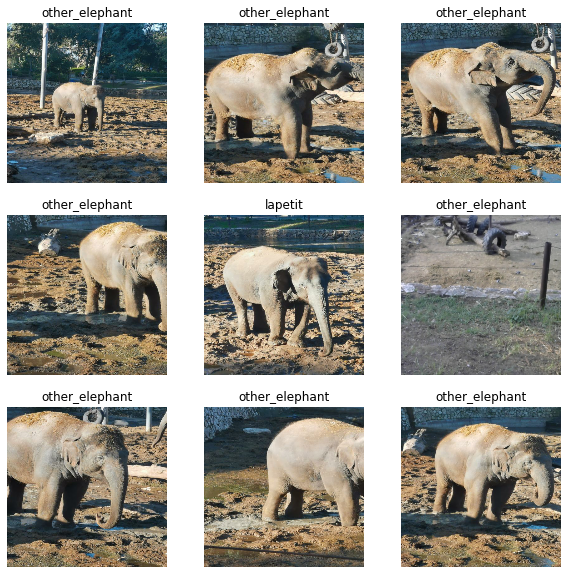

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 6
Number of test batches: 1


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation1 = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

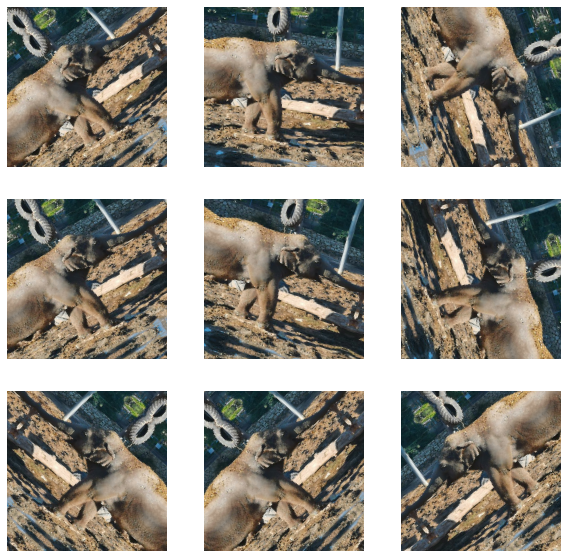

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image =  image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image1 = data_augmentation1(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image1[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
# rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation1(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

2

In [ ]:
initial_epochs = 110

loss0, accuracy0 = model.evaluate(validation_dataset)

6/6 [==============================] - 4s 109ms/step - loss: 0.6565 - accuracy: 0.4940


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.66
initial accuracy: 0.49


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/110
41/41 [==============================] - 9s 97ms/step - loss: 0.7396 - accuracy: 0.4609 - val_loss: 0.6389 - val_accuracy: 0.7440
Epoch 2/110
41/41 [==============================] - 4s 89ms/step - loss: 0.4975 - accuracy: 0.7312 - val_loss: 0.6944 - val_accuracy: 0.6310
Epoch 3/110
41/41 [==============================] - 4s 92ms/step - loss: 0.4425 - accuracy: 0.7870 - val_loss: 0.6291 - val_accuracy: 0.7143
Epoch 4/110
41/41 [==============================] - 4s 91ms/step - loss: 0.4329 - accuracy: 0.8056 - val_loss: 0.5712 - val_accuracy: 0.8036
Epoch 5/110
41/41 [==============================] - 4s 89ms/step - loss: 0.3984 - accuracy: 0.8304 - val_loss: 0.5467 - val_accuracy: 0.8155
Epoch 6/110
41/41 [==============================] - 4s 88ms/step - loss: 0.3735 - accuracy: 0.8435 - val_loss: 0.5218 - val_accuracy: 0.8631
Epoch 7/110
41/41 [==============================] - 4s 90ms/step - loss: 0.3487 - accuracy: 0.8629 - val_loss: 0.5148 - val_accuracy: 0.8750
Epoch 

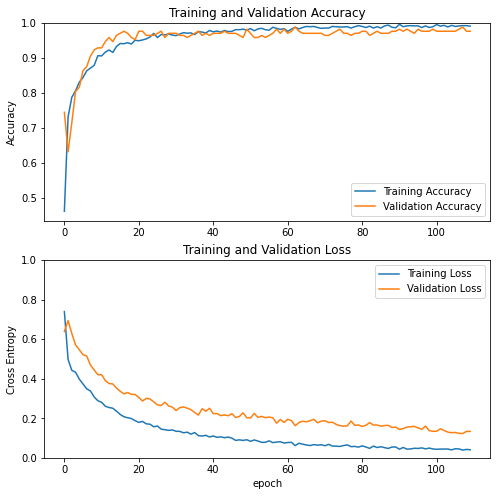

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

56

In [ ]:
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 110/140
41/41 [==============================] - 13s 131ms/step - loss: 0.0418 - accuracy: 0.9845 - val_loss: 0.0594 - val_accuracy: 1.0000
Epoch 111/140
41/41 [==============================] - 5s 102ms/step - loss: 0.0246 - accuracy: 0.9899 - val_loss: 0.0235 - val_accuracy: 1.0000
Epoch 112/140
41/41 [==============================] - 5s 104ms/step - loss: 0.0150 - accuracy: 0.9969 - val_loss: 0.0128 - val_accuracy: 1.0000
Epoch 113/140
41/41 [==============================] - 5s 104ms/step - loss: 0.0084 - accuracy: 0.9985 - val_loss: 0.0425 - val_accuracy: 0.9821
Epoch 114/140
41/41 [==============================] - 6s 133ms/step - loss: 0.0081 - accuracy: 0.9985 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 115/140
41/41 [==============================] - 8s 161ms/step - loss: 0.0096 - accuracy: 0.9961 - val_loss: 8.7729e-04 - val_accuracy: 1.0000
Epoch 116/140
41/41 [==============================] - 7s 156ms/step - loss: 0.0073 - accuracy: 0.9977 - val_loss: 0.0018 - v

In [ ]:
model.save('model_lapetit.h5') # save model 1 after the training

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

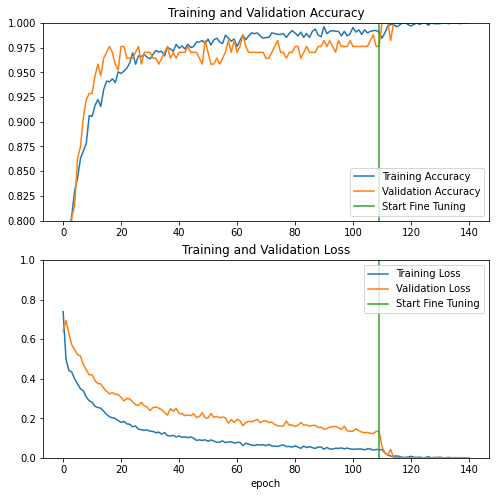

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 [==============================] - 0s 434ms/step - loss: 1.5287e-05 - accuracy: 1.0000
Test accuracy : 1.0


[-15.152483 -15.660067 -22.233217 -13.591436  18.598536]
Predictions:
 [0 0 0 0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 1 1 0 1 1 0]
Labels:
 [0 0 0 0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 1 1 0 1 1 0]
tf.Tensor(0.50000006, shape=(), dtype=float32)  =  tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(0.50000006, shape=(), dtype=float32)  =  tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(0.5, shape=(), dtype=float32)  =  tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(0.50000036, shape=(), dtype=float32)  =  tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(0.73105854, shape=(), dtype=float32)  =  tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(0.7310576, shape=(), dtype=float32)  =  tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(0.5, shape=(), dtype=float32)  =  tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(0.5, shape=(), dtype=float32)  =  tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(0.73105854, shape=(), dtype=float32)  =  tf.Tensor(1, shape=(), dtype=int32)


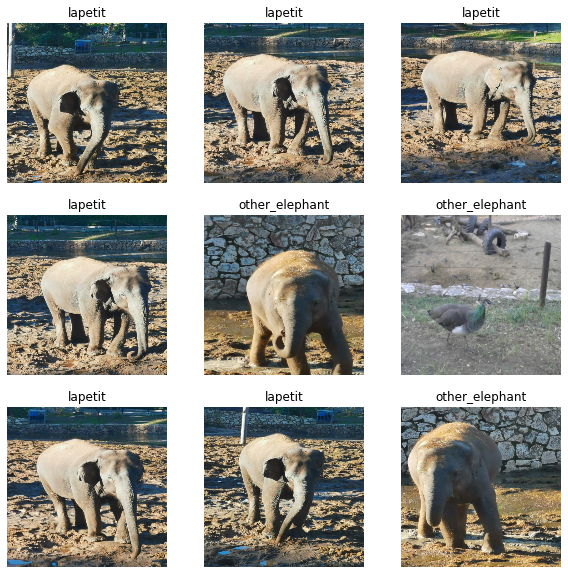

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
print (predictions[0:5])
predictions = tf.nn.sigmoid(predictions)
predictions_temp = tf.nn.sigmoid(predictions)

# print (predictions[0:5])
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")
  print(predictions_temp[i] ," = ", predictions[i])

In [ ]:
!wget 'https://firebasestorage.googleapis.com/v0/b/eleproje.appspot.com/o/model_lapetit.h5?alt=media&token=3fb4ab73-d9f4-4640-b5c7-7adbdd51b2c7' -O model_lapetit.h5

In [ ]:
model = tf.keras.models.load_model('model.h5')  # We will upload the best model
                                                  # and use it to continue the project

### Load a new image to predict if the elephant is La Petite.

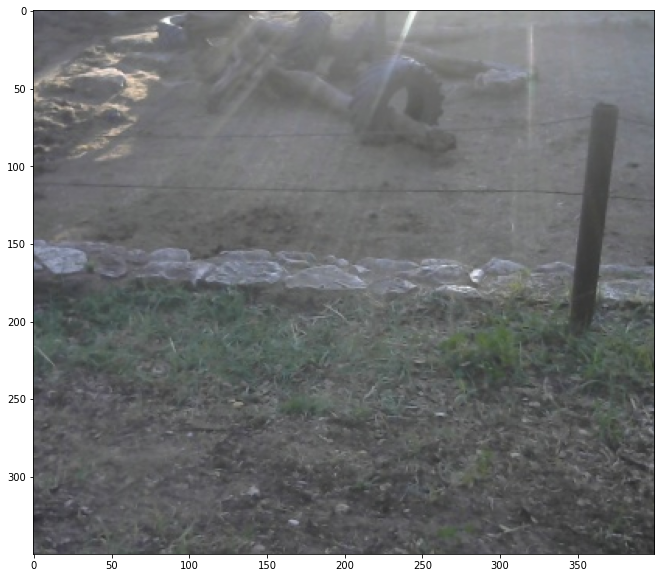

In [ ]:
#uplaod elephant image
plt.figure(figsize=(20,10))
#image = cv2.imread("latangi.jpg")
#image = cv2.imread("lapetit.jpg")
#image = cv2.imread("label.jpg")
image = cv2.imread("test.jpg")

image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image)

Now we need to resize the image to 512,512 , and then to resize it again to 160*160 like the model.


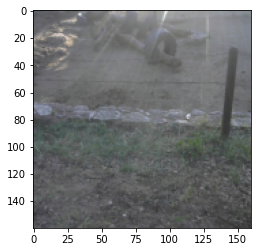

In [ ]:
dim = (160 ,160)
image160 = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
image160.shape
plt.imshow(image160)

In [ ]:
image160.astype("float32")
plt.imshow(image160)
print(image160.shape)

In [ ]:
def get_from_the_large_image_test_set(large_image): 
  
  l = []
  print(large_image.__class__)
  if(large_image.__class__ is not  list):
    l.append(large_image)
    return np.asarray(l)
 
  for i in large_image:
    l.append(i)

  return np.asarray(l)

## Predicte one image without any random flip

In [ ]:
# image160.astype("uint8")
i = get_from_the_large_image_test_set(image160)
i.shape

<class 'numpy.ndarray'>


(1, 160, 160, 3)

In [ ]:
predict_data = model.predict(i)  # predict test data
predict_data

array([[1.2006596]], dtype=float32)

In [ ]:
predictions2 = tf.nn.sigmoid(predict_data)
print('Predictions:\n', predictions2)
predictions = tf.where(predictions2 < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())

if predictions == 0:
  print('The elephant is Lapetit')
else:
  print ('The elephant is Not Lapetit')


Predictions:
 tf.Tensor([[0.7686421]], shape=(1, 1), dtype=float32)
Predictions:
 [[1]]
The elephant is Not Lapetit


## Predicte 9 images with random flip.

In [ ]:
data_augmentation1 = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomZoom(.3, .1)
])

In [ ]:
ll = []
plt.figure(figsize=(10, 10))
first_image = image160 
for j in range(9):
  ax = plt.subplot(3, 3, j + 1)
  augmented_image1 = data_augmentation1(tf.expand_dims(first_image, 0))
  ll.append(augmented_image1[0])
  plt.imshow(ll[j].numpy().astype("uint8"))
  plt.axis('off')



In [ ]:
plt.imshow(ll[0].numpy().astype("uint8"))


In [ ]:
i = get_from_the_large_image_test_set(ll)

In [ ]:
predict_data = model.predict(i)  # predict test data
predict_data

In [ ]:
predictions1 = tf.nn.sigmoid(predict_data)
print('Predictions:\n', predictions1)
predictions3 = tf.where(predictions1 < 0.5, 0, 1)

print('Predictions:\n', predictions3.numpy())

for x in predictions3 :
  if x == 0:
    print('The elephant is Lapetit')
   

  else:
    print('The elephant is Not Lapetit')
 




In [ ]:
print (predictions1.numpy())
print (predictions2.numpy())
for x in predictions1:
  error = (x - predictions2)*100

  print(error.numpy())

